In [11]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns

import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from skimage.io import imread
%matplotlib inline

In [ ]:
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D

In [29]:
from os import listdir
from os.path import join, isfile
files = listdir("../datasets/Breast_Histopathology")
print(len(files))

281


Each patch’s file name is of the format: uxXyYclassC.png — > example 10253idx5x1351y1101class0.png . Where u is the patient ID (10253idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC.



In [42]:
base_path = "../datasets/Breast_Histopathology/IDC_regular_ps50_idx5"
folder = listdir(base_path)
len(folder)

280

In [43]:
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + "/" + patient_id 
        if patient_path == "../datasets/Breast_Histopathology/IDC_regular_ps50_idx5/.DS_Store":
            continue
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [44]:
total_images 

277524

In [47]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + "/" + patient_id 
    if patient_path != "../datasets/Breast_Histopathology/IDC_regular_ps50_idx5/.DS_Store":
        for c in [0,1]:
            class_path = patient_path + "/" + str(c) + "/"
            subfiles = listdir(class_path)
            for m in range(len(subfiles)):
                image_path = subfiles[m]
                data.iloc[k]["path"] = class_path + image_path
                data.iloc[k]["target"] = c
                data.iloc[k]["patient_id"] = patient_id
                k += 1  

data.head()

,patient_id,path,target
0,9036,../datasets/Breast_Histopathology/IDC_regular_...,0
1,9036,../datasets/Breast_Histopathology/IDC_regular_...,0
2,9036,../datasets/Breast_Histopathology/IDC_regular_...,0
3,9036,../datasets/Breast_Histopathology/IDC_regular_...,0
4,9036,../datasets/Breast_Histopathology/IDC_regular_...,0


In [48]:
data.tail()

,patient_id,path,target
277519,8957,../datasets/Breast_Histopathology/IDC_regular_...,1
277520,8957,../datasets/Breast_Histopathology/IDC_regular_...,1
277521,8957,../datasets/Breast_Histopathology/IDC_regular_...,1
277522,8957,../datasets/Breast_Histopathology/IDC_regular_...,1
277523,8957,../datasets/Breast_Histopathology/IDC_regular_...,1


In [50]:
data.target = data.target.astype(np.int)

In [51]:
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

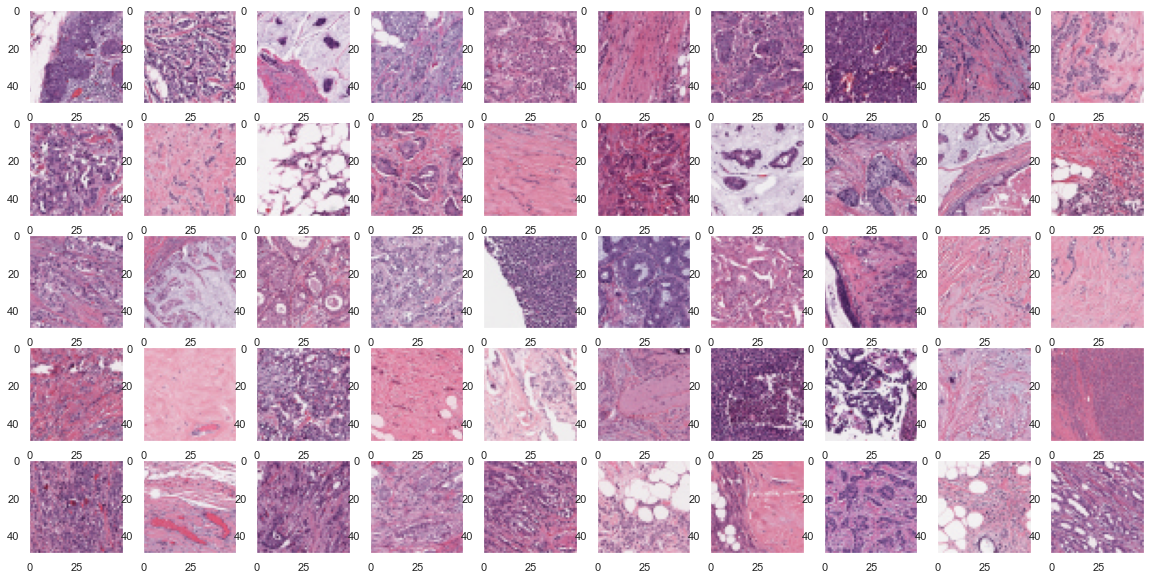

In [52]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

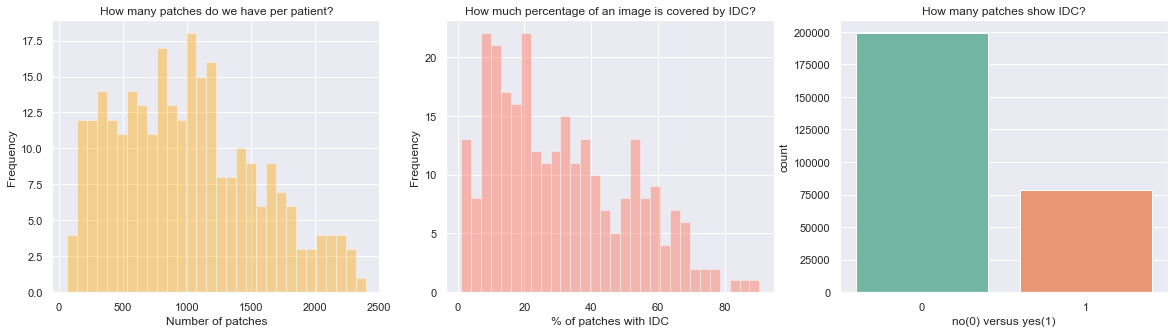

In [53]:
cancer_perc = data.groupby("patient_id").target.value_counts()/ data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(data.target, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");
